In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE = [256, 256]
batch_size = 32
input_path = "/Users/dipit/PlantImages/dataset/Grape Leaves/"
folders = glob(input_path + 'train/*')
folders

['/Users/dipit/PlantImages/dataset/Grape Leaves/train/Healthy',
 '/Users/dipit/PlantImages/dataset/Grape Leaves/train/Leaf_blight_(Isariopsis_Leaf_Spot)',
 '/Users/dipit/PlantImages/dataset/Grape Leaves/train/Esca_(Black_Measles)',
 '/Users/dipit/PlantImages/dataset/Grape Leaves/train/Black_rot']

In [3]:
from keras.applications.inception_v3 import InceptionV3

def build_model():
    inputs = layers.Input(shape = (IMAGE_SIZE + [3]))
    inception = InceptionV3(input_tensor = inputs,
                           weights = 'imagenet',
                           include_top = True)
    last_layer = inception.get_layer('avg_pool').output
    x = layers.Flatten()(last_layer)
    outputs = layers.Dense(len(folders), activation = 'softmax')(x)
    model = models.Model(inputs = inputs, outputs = outputs)
    return model

In [4]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
for layer in model.layers[:-1]:
    layer.trainable = False

In [6]:
model.compile(loss = "categorical_crossentropy",
             optimizer = "adam",
             metrics = ['accuracy'])

In [7]:
def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)
    
    test_datagen = ImageDataGenerator(rescale = 1./255)
    
    train_generator = train_datagen.flow_from_directory(
        directory = input_path + "train",
        target_size = (img_dims),
        batch_size = batch_size,
        class_mode = "categorical"
    )
    
    test_generator = test_datagen.flow_from_directory(
        directory = input_path + "test",
        target_size = (img_dims),
        batch_size = batch_size,
        class_mode = "categorical"
    )
    return train_generator, test_generator

In [8]:
train_data, test_data = process_data(IMAGE_SIZE, batch_size)

Found 2227 images belonging to 4 classes.
Found 850 images belonging to 4 classes.


In [9]:
history = model.fit(
    train_data, epochs = 10,
    validation_data = test_data
)

Epoch 1/10
70/70 [==============================] - 254s 4s/step - loss: 0.7576 - accuracy: 0.7080 - val_loss: 0.3355 - val_accuracy: 0.8729
Epoch 2/10
70/70 [==============================] - 247s 4s/step - loss: 0.2126 - accuracy: 0.9326 - val_loss: 0.1842 - val_accuracy: 0.9529
Epoch 3/10
70/70 [==============================] - 247s 4s/step - loss: 0.1514 - accuracy: 0.9566 - val_loss: 0.1452 - val_accuracy: 0.9635
Epoch 4/10
70/70 [==============================] - 248s 4s/step - loss: 0.1164 - accuracy: 0.9653 - val_loss: 0.1216 - val_accuracy: 0.9635
Epoch 5/10
70/70 [==============================] - 249s 4s/step - loss: 0.1061 - accuracy: 0.9697 - val_loss: 0.1312 - val_accuracy: 0.9553
Epoch 6/10
70/70 [==============================] - 250s 4s/step - loss: 0.0952 - accuracy: 0.9722 - val_loss: 0.1033 - val_accuracy: 0.9682
Epoch 7/10
70/70 [==============================] - 249s 4s/step - loss: 0.0701 - accuracy: 0.9798 - val_loss: 0.0890 - val_accuracy: 0.9765
Epoch 8/10
70

In [10]:
model.save('GrapeLeafDiseaseInception.h5')

In [11]:
scores = model.evaluate(test_data, verbose = 1)
print('Loss: ',scores[0])
print("Accuracy: ",scores[1])

27/27 [==============================] - 83s 3s/step - loss: 0.0827 - accuracy: 0.9741
Loss:  0.08268392086029053
Accuracy:  0.974117636680603


In [12]:
prediction = model.predict(test_data, verbose = 1)
y_pred = np.argmax(prediction, axis=1)

27/27 [==============================] - 116s 4s/step


In [13]:
class_labels = test_data.class_indices
class_labels = {v:k for k,v in class_labels.items()}
classes = list(class_labels.values())
classes

['Black rot',
 'Esca_(Black_Measles)',
 'Healthy',
 'Leaf_blight_(Isariopsis_Leaf_Spot)']

In [14]:
print("Confusion Matrix")
print(confusion_matrix(test_data.classes, y_pred))
print("Classification Report")
print(classification_report(test_data.classes, y_pred, target_names = classes))

Confusion Matrix
[[ 52  42  40  66]
 [ 40  26  39  45]
 [ 51  27  47  75]
 [ 63  47  73 117]]
Classification Report
                                    precision    recall  f1-score   support

                         Black rot       0.25      0.26      0.26       200
              Esca_(Black_Measles)       0.18      0.17      0.18       150
                           Healthy       0.24      0.23      0.24       200
Leaf_blight_(Isariopsis_Leaf_Spot)       0.39      0.39      0.39       300

                          accuracy                           0.28       850
                         macro avg       0.26      0.26      0.26       850
                      weighted avg       0.28      0.28      0.28       850



This image is of:  black rot


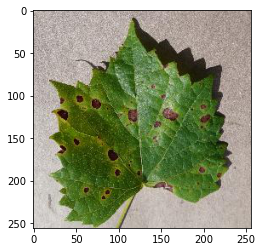

In [18]:
img = load_img('/Users/dipit/PlantImages/dataset/Grape Leaves/test/Black rot/ee45e010-fd06-443a-b845-885ebbcebfd8___FAM_B.Rot 3449.JPG',
              target_size = IMAGE_SIZE)
plt.imshow(img)
img = img_to_array(img)
x = img/255
x = np.expand_dims(x, axis=0)

prediction = model.predict(x)
prediction_c = np.argmax(prediction, axis = 1)

CLASSES = {
    'classes':['Black rot','Esca (Black Measles)','Healthy','Leaf_blight (Isariopsis Leaf Spot)']
}

predicted_class = CLASSES['classes'][prediction_c[0]]
print("This image is of: ",predicted_class.lower())

This image is of:  esca (black measles)


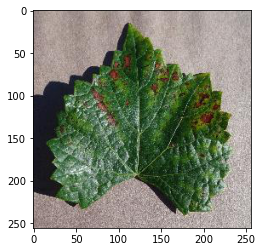

In [19]:
img = load_img('/Users/dipit/PlantImages/dataset/Grape Leaves/test/Esca_(Black_Measles)/fe707855-adf5-4a5f-ac65-6f8f977e97cc___FAM_B.Msls 1034.JPG',
              target_size = IMAGE_SIZE)
plt.imshow(img)
img = img_to_array(img)
x = img/255
x = np.expand_dims(x, axis=0)

prediction = model.predict(x)
prediction_c = np.argmax(prediction, axis = 1)

CLASSES = {
    'classes':['Black rot','Esca (Black Measles)','Healthy','Leaf_blight (Isariopsis Leaf Spot)']
}

predicted_class = CLASSES['classes'][prediction_c[0]]
print("This image is of: ",predicted_class.lower())

This image is of:  leaf_blight (isariopsis leaf spot)


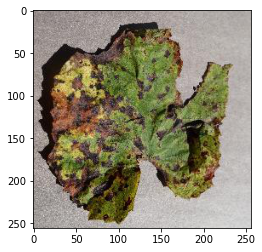

In [20]:
img = load_img('/Users/dipit/PlantImages/dataset/Grape Leaves/test/Leaf_blight_(Isariopsis_Leaf_Spot)/ef785c3d-bc95-4e10-b184-34d0aa07c2ea___FAM_L.Blight 4901.JPG',
              target_size = IMAGE_SIZE)
plt.imshow(img)
img = img_to_array(img)
x = img/255
x = np.expand_dims(x, axis=0)

prediction = model.predict(x)
prediction_c = np.argmax(prediction, axis = 1)

CLASSES = {
    'classes':['Black rot','Esca (Black Measles)','Healthy','Leaf_blight (Isariopsis Leaf Spot)']
}

predicted_class = CLASSES['classes'][prediction_c[0]]
print("This image is of: ",predicted_class.lower())